In [976]:
import pandas as pd
from sklearn.neighbors import KNeighborsRegressor
from sklearn.model_selection import train_test_split, ShuffleSplit
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import ElasticNet
from sklearn.metrics import mean_squared_log_error 
from sklearn.model_selection import cross_val_score, KFold
from sklearn.metrics import log_loss, mean_squared_error 
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import ast
import json
import math
from sklearn.svm import SVR
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestRegressor

In [1049]:
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')

In [1050]:
train['has_collection'] = train['belongs_to_collection'].apply(lambda x: 0 if type(x) is float else 1)
train.loc[train["budget"]<10000,"budget"]=10000
train.loc[train["genres"].notnull(),"genres"]=train.loc[train["genres"].notnull(),"genres"].apply(lambda x : ast.literal_eval(x))
train["genres"]=train["genres"].apply(lambda x: x[0]['name'] if type(x) is not float else 'None')
train['has_homepage'] = train['homepage'].apply(lambda x: 1 if type(x) is float else 100)
train.drop(['imdb_id','original_title','overview','poster_path','cast','crew'], inplace=True, axis=1)
train['release_year'] = train['release_date'].apply(lambda x: x.split('/')[2])
train['runtime'].fillna(train['runtime'].mean(), inplace=True);
train.loc[train["production_companies"].notnull(),"production_companies"]=train.loc[train["production_companies"].notnull(),"production_companies"].apply(lambda x : ast.literal_eval(x))
train["production_companies_num"]=train["production_companies"].apply(lambda x: len(x) if type(x) is not float else 1)
train.loc[train["production_countries"].notnull(),"production_countries"]=train.loc[train["production_countries"].notnull(),"production_countries"].apply(lambda x : ast.literal_eval(x))
train["production_countries_first"]=train["production_countries"].apply(lambda x: x[0]['iso_3166_1'] if type(x) is not float else 'None')
train.loc[train["spoken_languages"].notnull(),"spoken_languages"]=train.loc[train["spoken_languages"].notnull(),"spoken_languages"].apply(lambda x : ast.literal_eval(x))
train["spoken_languages_num"]=train["spoken_languages"].apply(lambda x: len(x) if type(x) is not float else 1)
train['tagline']=train['tagline'].apply(lambda x: 1 if type(x) is not float else 1)
train['title_num']= train['title'].apply(lambda x: sum(train['title']==x))
train.loc[train["Keywords"].notnull(),"Keywords"]=train.loc[train["Keywords"].notnull(),"Keywords"].apply(lambda x : ast.literal_eval(x))
train["keywords_num"]=train["Keywords"].apply(lambda x: len(x) if type(x) is not float else 1)
train['release_month'] = train.release_date.str.extract('(\S+)/\S+/\S+', expand=False).astype(np.int16)
train['release_year'] = train.release_date.str.extract('\S+/\S+/(\S+)', expand=False).astype(np.int16)
train['release_day'] = train.release_date.str.extract('\S+/(\S+)/\S+', expand=False).astype(np.int16)
train.loc[(21 <= train.release_year) & (train.release_year <= 99), 'release_year'] += 1900
train.loc[train.release_year < 21, 'release_year'] += 2000

train['release_date'] = pd.to_datetime(train.release_day.astype(str) + '-' + 
                                       train.release_month.astype(str) + '-' + 
                                       train.release_year.astype(str))

train['release_weekday'] = train.release_date.dt.weekday_name.str.slice(0, 3)

In [1051]:
def rmsle(y_test, y_pred):
    """
    :param: y, y_pred, real and predicted values
    :return: val, where y is a number
    """
    for i in range(len(y_pred)):
        if y_test[i] <= 0 or y_pred[i] <= 0:
            y_test[i] = 1
            y_pred[i] = 1
    return np.sqrt(mean_squared_log_error(y_test, y_pred))

In [1202]:
def featurize(movie):
    """
    :param datum: single movie information in dict
    :return: (x, y) tuple, where x is a numpy vector, and y is a number
    """
    dummy = [1, movie['title_num'], 
             movie['popularity'], movie['has_collection'], 
             movie['title_num']]
    
    def poly(x,m):
        for i in range (1,m+1):
            dummy.append(x**i)
            
    if (movie['runtime'] > 80.0) and (movie['runtime'] < 200.0):
        runtime = 20000
    else: 
        runtime = 100
        
    if movie['keywords_num'] <= 25:
        key_n = 1000000
    else: 
        key_n = 6000
        
    if (movie['production_companies_num'] < 7.5):
        prd = 1000000
    else:
        prd = 400000
        
    if movie['release_weekday'] == "Tue" or movie['release_weekday'] == "Wed":
        rev_wd = 1100
    elif movie['release_weekday'] == "Mon" or movie['release_weekday'] == "Thu":
        rev_wd = 700
    else:
        rev_wd = 500
    
    if movie['release_month'] == 6:
        rev_mon = 1000
    elif movie['release_month'] == 5 or movie['release_month'] == 7 or movie['release_month'] == 12:
        rev_mon = 800
    elif movie['release_month'] == 11:
        rev_mon = 650
    else:
        rev_mon = 350
        
    if movie['release_year'] > 2016:
        rev_y = 175
    elif movie['release_year'] > 1990:
        rev_y = 75
    else:
        rev_y = 40
    if movie['original_language'] == 'en' or movie['original_language'] == 'zh':
        lang_or = 700
    elif movie['original_language'] == 'tr':
        lang_or = 500
    else:
        lang_or = 150
        
    if movie['status'] == 'Released':
        status = 1000
    else:
        status = 1
    
    if movie['genres'] == 'Adventure' or movie['genres'] == 'Family' or movie['genres'] == 'Fantasy':
        gen = 600
    elif [movie['genres'] == 'Action' or movie['genres'] == 'Animation'
    or movie['genres'] == 'Science Fiction' or movie['genres'] == 'TV Movie']:
        gen = 350
    else:
        gen = 170
        
             
    poly(movie['popularity'], 4)
    poly(movie['title_num'], 4)
    poly(runtime, 2)
    poly(prd, 2)
    poly(key_n, 2)
    poly(status, 1)
    #poly(lang_or, 1)
    dummy.append(gen)
    poly(movie['budget'], 1)
            
    fin = np.array(dummy)
    return fin, movie['revenue'] 

In [1203]:
def get_data(df):
    """
    :param df: movie infomation in DataFrame
    :return: X, Y, where X(each row is a data element) is matrix and Y(response vector)
    """
    X, Y = [], []
    for _, datum in df.iterrows():
        x, y = featurize(dict(datum))
        X.append(x)
        Y.append(y)
    return np.array(X), np.array(Y)

In [1204]:
data, target = get_data(train)

In [1205]:
x_train, x_val, y_train, y_val = train_test_split(data, target, test_size=0.3, random_state=69)

In [1206]:
model_regr = ElasticNet(alpha=69, random_state=69, max_iter=100000)

In [1207]:
model_regr.fit(x_train, y_train)

C:\Users\nitro\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


ElasticNet(alpha=69, copy_X=True, fit_intercept=True, l1_ratio=0.5,
      max_iter=100000, normalize=False, positive=False, precompute=False,
      random_state=69, selection='cyclic', tol=0.0001, warm_start=False)

In [1208]:
y_pred = model_regr.predict(x_val)

In [1226]:
mean_squared_error(y_val, y_pred)

6613731822164966.0

In [1210]:
rmsle(y_val, y_pred) 

1.8431827579976505

In [1090]:
train.head()

,id,belongs_to_collection,budget,genres,homepage,original_language,popularity,production_companies,production_countries,release_date,...,has_homepage,release_year,production_companies_num,production_countries_first,spoken_languages_num,title_num,keywords_num,release_month,release_day,release_weekday
0,1,"[{'id': 313576, 'name': 'Hot Tub Time Machine ...",14000000,Comedy,NaN,en,6.575393,"[{'name': 'Paramount Pictures', 'id': 4}, {'na...","[{'iso_3166_1': 'US', 'name': 'United States o...",2015-02-20,...,1,2015,3,US,1,1,4,2,20,Fri
1,2,"[{'id': 107674, 'name': 'The Princess Diaries ...",40000000,Comedy,NaN,en,8.248895,"[{'name': 'Walt Disney Pictures', 'id': 2}]","[{'iso_3166_1': 'US', 'name': 'United States o...",2004-06-08,...,1,2004,1,US,1,1,4,8,6,Tue
2,3,NaN,3300000,Drama,http://sonyclassics.com/whiplash/,en,64.299990,"[{'name': 'Bold Films', 'id': 2266}, {'name': ...","[{'iso_3166_1': 'US', 'name': 'United States o...",2014-10-10,...,100,2014,3,US,1,1,12,10,10,Fri
3,4,NaN,1200000,Thriller,http://kahaanithefilm.com/,hi,3.174936,NaN,"[{'iso_3166_1': 'IN', 'name': 'India'}]",2012-09-03,...,100,2012,1,IN,2,1,7,3,9,Mon
4,5,NaN,10000,Action,NaN,ko,1.148070,NaN,"[{'iso_3166_1': 'KR', 'name': 'South Korea'}]",2009-05-02,...,1,2009,1,KR,1,1,1,2,5,Sat


[Text(0, 0.5, 'mean of revenue')]

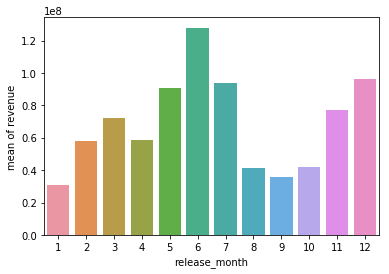

In [1182]:
revenue_by_month = train.groupby('release_month')['revenue'].aggregate([np.mean])
revenue_by_month.reset_index(inplace=True)
fig =sns.barplot(x='release_month', y='mean', data=revenue_by_month)
fig.set(ylabel='mean of revenue')

In [1240]:
from catboost import CatBoostRegressor

In [1241]:
model_cat = CatBoostRegressor(iterations=1000, eval_metric='RMSE', 
                              early_stopping_rounds=200,
                              metric_period=None, depth=8,
                              learning_rate=0.043, colsample_bylevel=0.153,
                              bagging_temperature=0.063)

In [1242]:
model_cat.fit(x_train, y_train)

0:	learn: 158049364.9745332	total: 13.9ms	remaining: 13.9s
1:	learn: 154590921.5348270	total: 109ms	remaining: 54.5s
2:	learn: 150807067.1329765	total: 201ms	remaining: 1m 6s
3:	learn: 147689066.0478169	total: 233ms	remaining: 58.1s
4:	learn: 144165074.9121052	total: 321ms	remaining: 1m 3s
5:	learn: 140768967.3565583	total: 413ms	remaining: 1m 8s
6:	learn: 137770590.2833142	total: 461ms	remaining: 1m 5s
7:	learn: 135140497.9238521	total: 566ms	remaining: 1m 10s
8:	learn: 132301532.5987217	total: 611ms	remaining: 1m 7s
9:	learn: 129506738.3877811	total: 654ms	remaining: 1m 4s
10:	learn: 127028209.3919514	total: 722ms	remaining: 1m 4s
11:	learn: 124844835.2149195	total: 806ms	remaining: 1m 6s
12:	learn: 122439383.8955607	total: 859ms	remaining: 1m 5s
13:	learn: 120089662.8720928	total: 919ms	remaining: 1m 4s
14:	learn: 117977441.6507483	total: 954ms	remaining: 1m 2s
15:	learn: 116236851.1842188	total: 993ms	remaining: 1m 1s
16:	learn: 114201537.9023781	total: 1.03s	remaining: 59.8s
17:	l

In [1236]:
pred_cat = model_cat.predict(x_val)

In [1237]:
mean_squared_error(y_val, pred_cat)

5969241567131878.0

In [1238]:
rmsle(y_val, pred_cat) 

7.032621134558262

In [1266]:
test = pd.read_csv('test.csv')

In [1267]:
test['has_collection'] = test['belongs_to_collection'].apply(lambda x: 0 if type(x) is float else 1)
test.loc[test["budget"]<10000,"budget"]=10000
test.loc[test["genres"].notnull(),"genres"]=test.loc[test["genres"].notnull(),"genres"].apply(lambda x : ast.literal_eval(x))
test["genres"]=test["genres"].apply(lambda x: x[0]['name'] if type(x) is not float else 'None')
test['has_homepage'] = test['homepage'].apply(lambda x: 1 if type(x) is float else 100)
test.drop(['imdb_id','original_title','overview','poster_path','cast','crew'], inplace=True, axis=1)
test['runtime'].fillna(test['runtime'].mean(), inplace=True);
test.loc[test["production_companies"].notnull(),"production_companies"]=test.loc[test["production_companies"].notnull(),"production_companies"].apply(lambda x : ast.literal_eval(x))
test["production_companies_num"]=test["production_companies"].apply(lambda x: len(x) if type(x) is not float else 1)
test.loc[test["production_countries"].notnull(),"production_countries"]=test.loc[test["production_countries"].notnull(),"production_countries"].apply(lambda x : ast.literal_eval(x))
test["production_countries_first"]=test["production_countries"].apply(lambda x: x[0]['iso_3166_1'] if type(x) is not float else 'None')
test.loc[test["spoken_languages"].notnull(),"spoken_languages"]=test.loc[test["spoken_languages"].notnull(),"spoken_languages"].apply(lambda x : ast.literal_eval(x))
test["spoken_languages_num"]=test["spoken_languages"].apply(lambda x: len(x) if type(x) is not float else 1)
test['tagline']=test['tagline'].apply(lambda x: 1 if type(x) is not float else 1)
test['title_num']= test['title'].apply(lambda x: sum(test['title']==x))
test.loc[test["Keywords"].notnull(),"Keywords"]=test.loc[test["Keywords"].notnull(),"Keywords"].apply(lambda x : ast.literal_eval(x))
test["keywords_num"]=test["Keywords"].apply(lambda x: len(x) if type(x) is not float else 1)

In [1268]:
def featurize_test(movie):
    """
    :param datum: single movie information in dict
    :return: (x, y) tuple, where x is a numpy vector, and y is a number
    """
    dummy = [1, movie['title_num'], 
             movie['popularity'], movie['has_collection'], 
             movie['title_num']]
    
    def poly(x,m):
        for i in range (1,m+1):
            dummy.append(x**i)
            
    if (movie['runtime'] > 80.0) and (movie['runtime'] < 200.0):
        runtime = 20000
    else: 
        runtime = 100
        
    if movie['keywords_num'] <= 25:
        key_n = 1000000
    else: 
        key_n = 6000
        
    if (movie['production_companies_num'] < 7.5):
        prd = 1000000
    else:
        prd = 400000
    
    if movie['original_language'] == 'en' or movie['original_language'] == 'zh':
        lang_or = 700
    elif movie['original_language'] == 'tr':
        lang_or = 500
    else:
        lang_or = 150
        
    if movie['status'] == 'Released':
        status = 1000
    else:
        status = 1
    
    if movie['genres'] == 'Adventure' or movie['genres'] == 'Family' or movie['genres'] == 'Fantasy':
        gen = 600
    elif [movie['genres'] == 'Action' or movie['genres'] == 'Animation'
    or movie['genres'] == 'Science Fiction' or movie['genres'] == 'TV Movie']:
        gen = 350
    else:
        gen = 170
        
             
    poly(movie['popularity'], 4)
    poly(movie['title_num'], 4)
    poly(runtime, 2)
    poly(prd, 2)
    poly(key_n, 2)
    poly(status, 1)
    #poly(lang_or, 1)
    dummy.append(gen)
    poly(movie['budget'], 1)
            
    fin = np.array(dummy)
    return fin

In [1269]:
def get_data_test(df):
    """
    :param df: movie infomation in DataFrame
    :return: X, Y, where X(each row is a data element) is matrix and Y(response vector)
    """
    X = []
    for _, datum in df.iterrows():
        x = featurize_test(dict(datum))
        X.append(x)
    return np.array(X)

In [1270]:
test_data = get_data_test(test)

In [1274]:
pred_test_cat = model_cat.predict(test_data)
pred_test_reg = model_regr.predict(test_data)

In [1273]:
submission = pd.DataFrame({'id': np.arange(3001, 7399), 'revenue': pred_test_cat})
submission.to_csv('submission_cat.csv', index=None)

In [1275]:
submission = pd.DataFrame({'id': np.arange(3001, 7399), 'revenue': pred_test_reg})
submission.to_csv('submission_reg.csv', index=None)